# Advanced neural networks

&copy; 李浩东 3190104890@zju.edu.cn

- Modern Convolution Neural Network (CNN)
- Recurrent neural network (RNN)
- Natural language process (NLP)
- You only look once (YOLO)
- Some resources


# Learning Representations

- Up until 2012 the representation was calculated mechanically. In fact, engineering a new set of feature functions, improving results, and writing up the method was a prominent genre of paper. Like some functions in OpenCV.
- Features themselves ought to be learned, to be hierarchically composed with multiple jointly learned layers, each with learnable parameters.

![filters.png](./images/8/filters.png)


# AlexNet 

![ww](./images/8/alexnet.png)


# From LeNet (left) to AlexNet (right)

![alexnet.svg](./images/8/alexnet.svg)


In [1]:
import torch
from torch import nn

In [2]:
def alexnet():
    alexnet = nn.Sequential(
        # Here, we use a larger 11 x 11 window to capture objects. At the same
        # time, we use a stride of 4 to greatly reduce the height and width of the
        # output. Here, the number of output channels is much larger than that in
        # LeNet
        nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        # Make the convolution window smaller, set padding to 2 for consistent
        # height and width across the input and output, and increase the number of
        # output channels
        nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        # Use three successive convolutional layers and a smaller convolution
        # window. Except for the final convolutional layer, the number of output
        # channels is further increased. Pooling layers are not used to reduce the
        # height and width of input after the first two convolutional layers
        nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
        nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
        nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Flatten(),
        # Here, the number of outputs of the fully-connected layer is several
        # times larger than that in LeNet. Use the dropout layer to mitigate
        # overfitting
        nn.Linear(6400, 4096), nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(4096, 4096), nn.ReLU(),
        nn.Dropout(p=0.5),
        # Output layer. Since we are using CIFAR-10, the number of classes is
        # 10, instead of 1000 as in the paper
        nn.Linear(4096, 10))
    return alexnet

In [3]:
X = torch.randn(128, 3, 224, 224)
alex = alexnet()
for layer in alex:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Conv2d output shape:	 torch.Size([128, 96, 54, 54])
ReLU output shape:	 torch.Size([128, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([128, 96, 26, 26])
Conv2d output shape:	 torch.Size([128, 256, 26, 26])
ReLU output shape:	 torch.Size([128, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([128, 256, 12, 12])
Conv2d output shape:	 torch.Size([128, 384, 12, 12])
ReLU output shape:	 torch.Size([128, 384, 12, 12])
Conv2d output shape:	 torch.Size([128, 384, 12, 12])
ReLU output shape:	 torch.Size([128, 384, 12, 12])
Conv2d output shape:	 torch.Size([128, 256, 12, 12])
ReLU output shape:	 torch.Size([128, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([128, 256, 5, 5])
Flatten output shape:	 torch.Size([128, 6400])
Linear output shape:	 torch.Size([128, 4096])
ReLU output shape:	 torch.Size([128, 4096])
Dropout output shape:	 torch.Size([128, 4096])
Linear output shape:	 torch.Size([128, 4096])
ReLU output shape:	 torch.Size([128, 4096])
Dropout output shape:	 torch.Size([128, 409

In [4]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.model = alexnet()
    def forward(self, x):
        x = self.model(x)
        return x

In [5]:
print(alexnet())

Sequential(
  (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=6400, out_features=4096, bias=True)
  (15): ReLU()
  (16): Dropout(p=0.5, inplace=False)
  (17): Linear(in_features=4096, out_features=4096, bias=True)
  (18): ReLU()
  (19): Dropout(p=0.5, inplace=False)
  (20): Linear(in_featu

In [6]:
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [7]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize(224),
                                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                                ])
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)
print(len(train_data))
print(len(test_data))

Files already downloaded and verified
Files already downloaded and verified
50000
10000


In [8]:
num_workers = 0
batch_size = 128
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape)
print(labels.shape)

torch.Size([128, 3, 224, 224])
torch.Size([128])


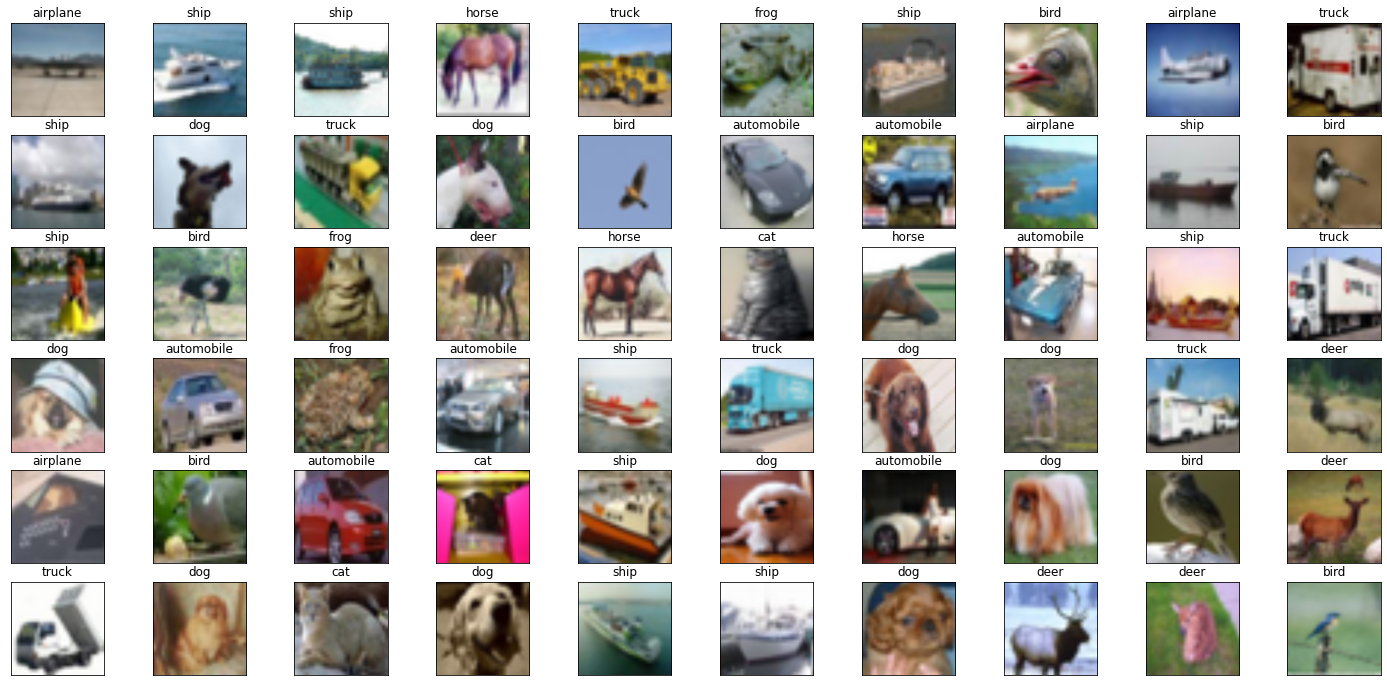

In [9]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display
fig = plt.figure(figsize=(25, 12))
for i in np.arange(60):
    ax = fig.add_subplot(6, 10, i+1, xticks=[], yticks=[])
    imshow(images[i])
    ax.set_title(classes[labels[i]])

<class 'numpy.ndarray'>
(3, 224, 224)


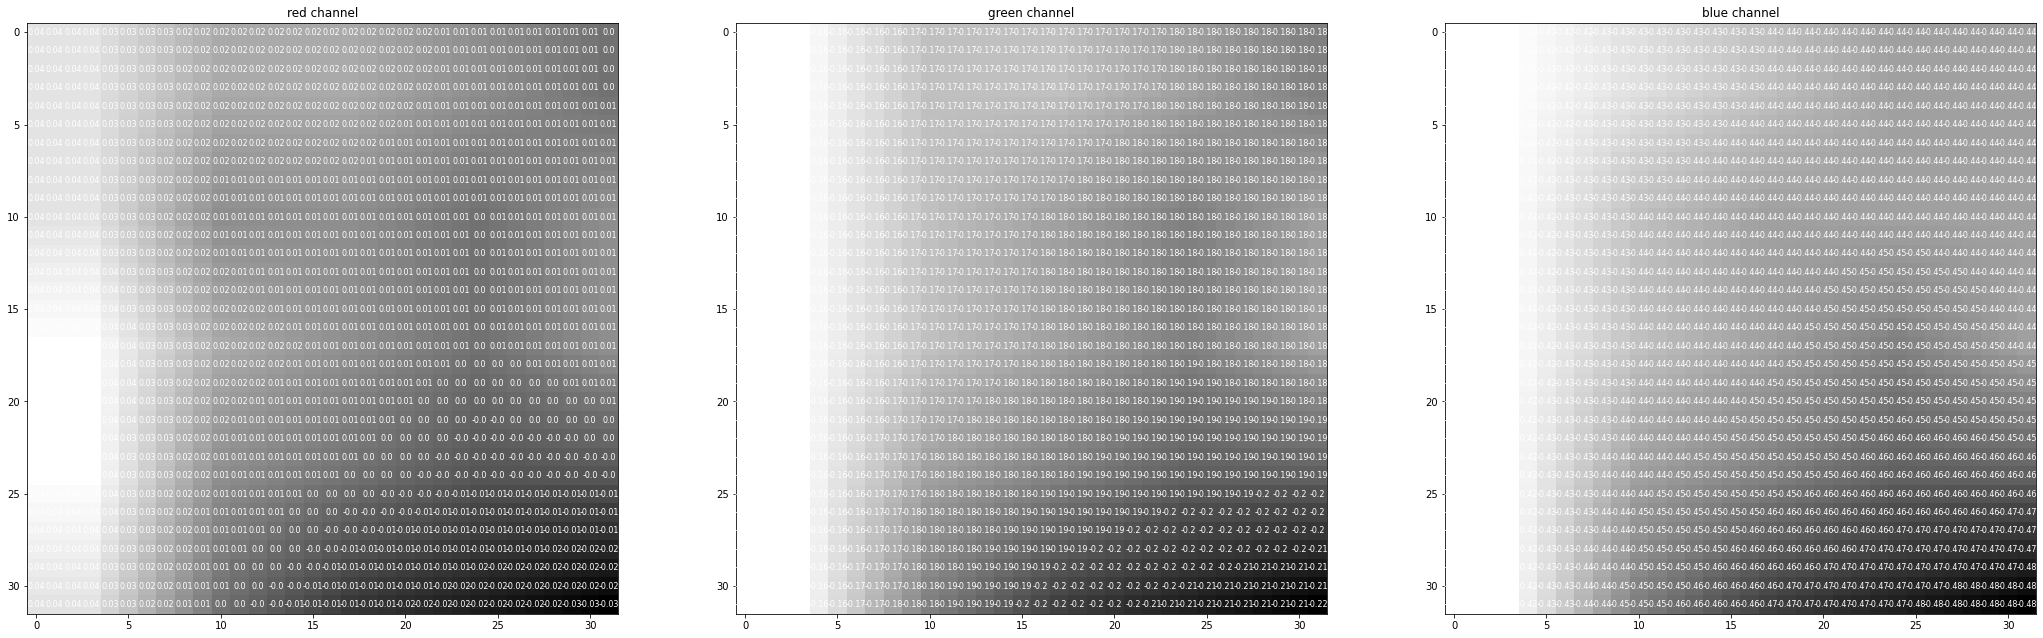

In [10]:
rgb_img = np.squeeze(images[19])
print(type(rgb_img))
print(rgb_img.shape)
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img[:32, :32], cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(32):
        for y in range(32):
            val = round(img[x][y], 2) if img[x][y] != 0 else 0
            ax.annotate(str(val), xy=(y,x),
                horizontalalignment='center',
                verticalalignment='center', size=8,
                color='white' if img[x][y] < thresh else 'black')

In [12]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def train_model(model, name, epoch_num=500,device='gpu'):
    if device == 'cuda':
        print("Use CUDA for training.")
        model = torch.nn.DataParallel(model) # make parallel
        cudnn.benchmark = True
        
    # specify loss function
    criterion = nn.CrossEntropyLoss()
    # specify optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    train_losslist = []
    valid_losslist = []
    train_acclist = []
    valid_acclist = []

    for epoch in range(1, epoch_num+1):
        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0.0
        valid_acc = 0.0

        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            acc = accuracy(output, target)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            train_acc += acc.item()*data.size(0)

        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            acc = accuracy(output, target)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
            valid_acc += acc.item()*data.size(0)

        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(test_loader.dataset)
        train_acc = train_acc/len(train_loader.dataset)
        valid_acc = valid_acc/len(test_loader.dataset)
        train_losslist.append(train_loss)
        valid_losslist.append(valid_loss)
        train_acclist.append(train_acc)
        valid_acclist.append(valid_acc)
        print("Epoch ->", epoch, "\t train_loss ->", train_loss, "\t\t\t train_acc ->", train_acc, 
              "\n==========\t valid_loss ->", valid_loss, "\t\t\t valid_acc ->", valid_acc)

    torch.save(model.state_dict(), 'cifar_' + name + '.pt')
    return train_acclist, valid_acclist, train_losslist, valid_losslist

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.get_arch_list())
train_acclist, valid_acclist, train_losslist, valid_losslist = train_model(AlexNet(), "alexnet", 2, device)

[]


KeyboardInterrupt: 

In [ ]:
def plot_accuracies(train_acclist, valid_acclist):
    plt.plot(train_acclist, '-rx')
    plt.plot(valid_acclist, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')

def plot_losses(train_losslist, valid_losslist):
    plt.plot(train_losslist, '-bx')
    plt.plot(valid_losslist, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

In [ ]:
plot_accuracies(train_acclist, valid_acclist)

In [ ]:
plot_losses(train_losslist, valid_losslist)

# Networks Using Blocks (VGG)

![vgg](./images/8/vgg.png)


# AlexNet V.S. VGG

![1](./images/8/vgg.svg)
